In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, False)
import numpy as np

from nif.optimizers import AdaBeliefOptimizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import time
import obspy
# plt.rc('text', usetex = True)
# plt.rc('font', family='serif')

2022-09-08 12:11:43.019461: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-08 12:11:43.857104: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-08 12:11:43.857804: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-08 12:11:44.029061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:4b:00.0 name: NVIDIA A100 80GB PCIe computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 79.20GiB deviceMemoryBandwidth: 1.76TiB/s
2022-09-08 12:11:44.029091: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-08 12:11:44.030422: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2

1 Physical GPUs, 1 Logical GPUs


In [2]:
class SIREN(tf.keras.layers.Layer):
    def __init__(self, num_inputs, num_outputs, layer_position,
                 omega_0, mixed_policy=tf.keras.mixed_precision.Policy('float32'),
                 **kwargs):
        super(SIREN, self).__init__(**kwargs)
        self.layer_position = layer_position
        self.compute_Dtype = mixed_policy.compute_dtype
        variable_Dtype = mixed_policy.variable_dtype
        self.omega_0 = omega_0

        # initialize the weights
        if layer_position == 'first':
            w_init = tf.random.uniform((num_inputs, num_outputs),
                                       -1. / num_inputs,
                                       1. / num_inputs,
                                       dtype=variable_Dtype)
            b_init = tf.random.uniform((num_outputs,),
                                       -1. / np.sqrt(num_inputs),
                                       1. / np.sqrt(num_inputs),
                                       dtype=variable_Dtype)
        else:
            w_init = tf.random.uniform((num_inputs, num_outputs),
                                       -tf.math.sqrt(6.0 / num_inputs) / self.omega_0,
                                       tf.math.sqrt(6.0 / num_inputs) / self.omega_0,
                                       dtype=variable_Dtype)
            b_init = tf.random.uniform((num_outputs,),
                                       -1. / np.sqrt(num_inputs),
                                       1. / np.sqrt(num_inputs),
                                       dtype=variable_Dtype)


        self.w_init = w_init
        self.b_init = b_init
        self.w = tf.Variable(w_init, dtype=variable_Dtype, name=kwargs.get('name', 'siren') + '_w')
        self.b = tf.Variable(b_init, dtype=variable_Dtype, name=kwargs.get('name', 'siren') + '_b')

    def call(self, x, **kwargs):
        if self.layer_position == 'first' or self.layer_position == 'hidden':
            y = tf.math.sin(self.omega_0 * tf.matmul(x, tf.cast(self.w, self.compute_Dtype)) +
                            tf.cast(self.b, self.compute_Dtype))
#             y = tf.keras.activations.relu(self.omega_0 * tf.matmul(x, tf.cast(self.w, self.compute_Dtype)) +
#                             tf.cast(self.b, self.compute_Dtype))
        else:
            y = tf.matmul(x, tf.cast(self.w, self.compute_Dtype)) + tf.cast(self.b, self.compute_Dtype)
        return y

    def get_config(self):
        config = super().get_config()
        config.update({
            # "num_inputs": self.num_inputs,
            # "num_outputs": self.num_outputs,
            "layer_position": self.layer_position,
            "omega_0": self.omega_0,
            # "cfg_shape_net": self.cfg_shape_net,
            # "mixed_policy": self.mixed_policy
        })
        return config

    def get_prunable_weights(self):
        return [self.w]

In [57]:
DR_PATH = f"/fd1/yiyu_data/OOI-training-15min-demean-0-14-XMIN25000-XMAX40000.npz"
TRAIN_DATA = np.load(DR_PATH)['raw'][::5,::5]
# TRAIN_DATA -= TRAIN_DATA.min()
TRAIN_DATA /= abs(TRAIN_DATA).max()

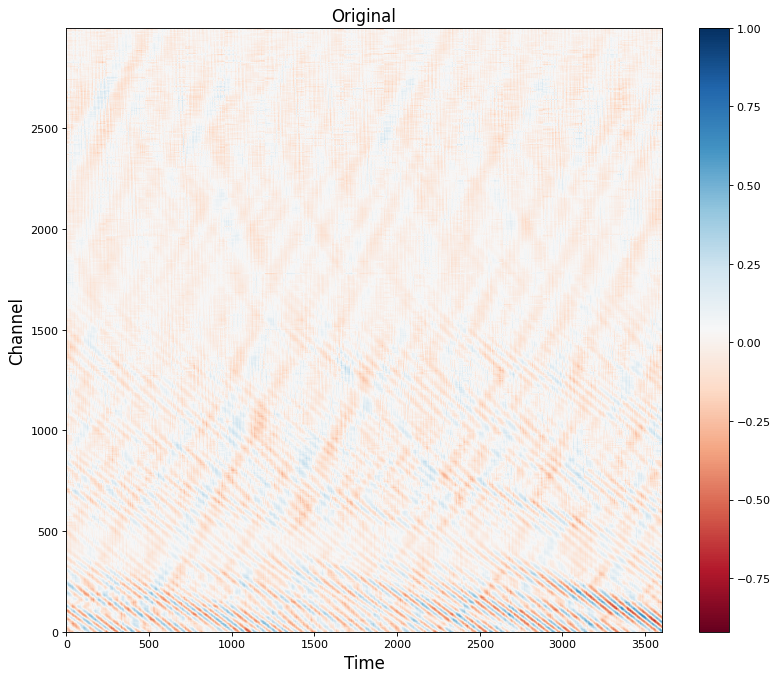

In [58]:
fig = plt.figure(figsize = (12, 10), dpi = 80)
plt.imshow(TRAIN_DATA, cmap = 'RdBu', aspect = 'auto', origin='lower')
plt.title("Original", fontsize = 15)
plt.ylabel("Channel", fontsize = 15)
plt.xlabel("Time", fontsize = 15)
plt.colorbar()

In [59]:
NX, NT = TRAIN_DATA.shape
t, x = np.meshgrid(np.arange(NT), np.arange(NX))
T = 2*t/(NT-1)-1; X = 2*x/(NX-1)-1
print(NX, NT)

3000 3600


In [60]:
test_data = np.concatenate([T.reshape([-1, 1]), X.reshape([-1, 1]), TRAIN_DATA.reshape([-1, 1])], axis = -1)
train_data = test_data[:, :]
print(test_data.shape)

(10800000, 3)


In [61]:
batch_size = 1024*16
num_total_data = train_data.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices((train_data[:, :(train_data.shape[-1]-1)],
                                                    train_data[:, (train_data.shape[-1]-1)]))
train_dataset = train_dataset.shuffle(int(num_total_data)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [62]:
#--------
UNITS = 128
LAYERS = 20

# compile
lr = 1e-5
# optimizer = AdaBeliefOptimizer(lr)
optimizer = tf.keras.optimizers.Adam(lr)

# create the model
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(train_data.shape[-1]-1,)))
model.add(SIREN(num_inputs=train_data.shape[-1]-1, num_outputs=UNITS, layer_position='first', omega_0=30.0, name='first'))
for i in range(LAYERS):
    model.add(SIREN(num_inputs=UNITS, num_outputs=UNITS, layer_position='hidden', omega_0=30.0, name='hidden_{}'.format(i)))
model.add(SIREN(num_inputs=UNITS, num_outputs=1, layer_position='last', omega_0=30.0, name='last'))
model.compile(optimizer=optimizer, loss='mse')
history_callback = tf.keras.callbacks.History()
callbacks = [history_callback]

nweights = 0
for i in model.get_weights():
    nweights += len(i.flatten())
print(f"have total {nweights} weigths")

have total 330753 weigths


In [63]:
#------------
t = time.time()
nepoch = 30
model.fit(train_dataset, epochs=nepoch, callbacks=callbacks, use_multiprocessing = True, shuffle = True)
print(f"took {(time.time() - t)/nepoch} for {nepoch} epoch")

Epoch 1/30
660/660 [==============================] - 33s 35ms/step - loss: 0.0064
Epoch 2/30
660/660 [==============================] - 33s 35ms/step - loss: 0.0038
Epoch 3/30
660/660 [==============================] - 34s 37ms/step - loss: 0.0037
Epoch 4/30


2022-09-09 00:02:29.084183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10718131 of 10800000
2022-09-09 00:02:29.278259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


660/660 [==============================] - 37s 40ms/step - loss: 0.0036
Epoch 5/30
660/660 [==============================] - 33s 35ms/step - loss: 0.0035
Epoch 6/30


2022-09-09 00:03:39.122577: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10214953 of 10800000


  5/660 [..............................] - ETA: 20s - loss: 0.0035  

2022-09-09 00:03:39.750136: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


660/660 [==============================] - 35s 37ms/step - loss: 0.0035
Epoch 7/30


2022-09-09 00:04:14.185606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10449163 of 10800000


  5/660 [..............................] - ETA: 18s - loss: 0.0035  

2022-09-09 00:04:14.430892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


660/660 [==============================] - 33s 35ms/step - loss: 0.0034
Epoch 8/30


2022-09-09 00:04:47.602233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10662770 of 10800000


  5/660 [..............................] - ETA: 19s - loss: 0.0034  

2022-09-09 00:04:47.917114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


660/660 [==============================] - 34s 36ms/step - loss: 0.0034
Epoch 9/30


2022-09-09 00:05:22.034720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8388386 of 10800000


  3/660 [..............................] - ETA: 26s - loss: 0.0034    

2022-09-09 00:05:26.927228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


660/660 [==============================] - 43s 42ms/step - loss: 0.0033
Epoch 10/30
660/660 [==============================] - 33s 36ms/step - loss: 0.0033
Epoch 11/30


2022-09-09 00:06:37.911992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10335789 of 10800000


  5/660 [..............................] - ETA: 20s - loss: 0.0033  

2022-09-09 00:06:38.257161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


660/660 [==============================] - 35s 37ms/step - loss: 0.0033
Epoch 12/30
660/660 [==============================] - 33s 35ms/step - loss: 0.0033
Epoch 13/30


2022-09-09 00:07:45.252755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8125754 of 10800000


  5/660 [..............................] - ETA: 21s - loss: 0.0032  

2022-09-09 00:07:53.190641: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


660/660 [==============================] - 42s 36ms/step - loss: 0.0032
Epoch 14/30


2022-09-09 00:08:27.151389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10215676 of 10800000


  3/660 [..............................] - ETA: 27s - loss: 0.0032    

2022-09-09 00:08:28.201581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


660/660 [==============================] - 46s 53ms/step - loss: 0.0032
Epoch 15/30


2022-09-09 00:09:13.342497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8970454 of 10800000


  3/660 [..............................] - ETA: 26s - loss: 0.0032    

2022-09-09 00:09:16.838301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


660/660 [==============================] - 47s 50ms/step - loss: 0.0032
Epoch 16/30


2022-09-09 00:10:00.270693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 10252065 of 10800000


  5/660 [..............................] - ETA: 20s - loss: 0.0032  

2022-09-09 00:10:01.475761: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


660/660 [==============================] - 37s 39ms/step - loss: 0.0031
Epoch 17/30


2022-09-09 00:10:37.621464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8977136 of 10800000


  5/660 [..............................] - ETA: 22s - loss: 0.0032  

2022-09-09 00:10:39.786664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


660/660 [==============================] - 40s 42ms/step - loss: 0.0031
Epoch 18/30


2022-09-09 00:11:17.669936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 8605402 of 10800000


  3/660 [..............................] - ETA: 29s - loss: 0.0031    

2022-09-09 00:11:21.226283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


610/660 [==========================>...] - ETA: 2s - loss: 0.0031

KeyboardInterrupt: 

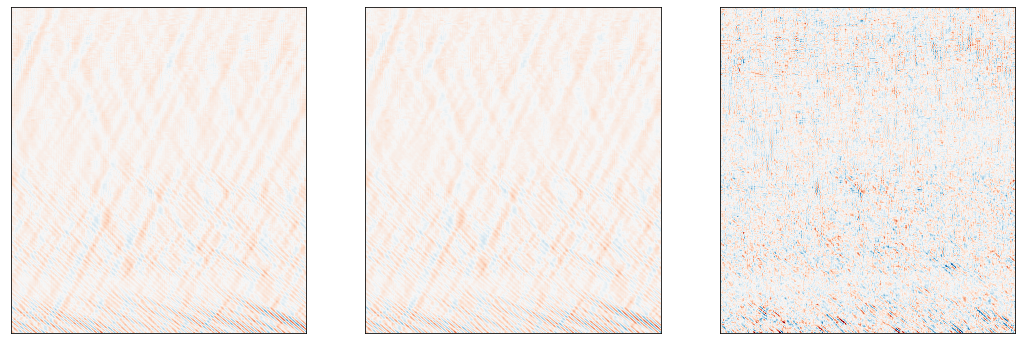

In [64]:
predict = np.array(model(test_data[:, :-1])).reshape([NX, NT])
plt.figure(figsize = (18, 6))
plt.subplot(1,3,1)
plt.imshow(TRAIN_DATA, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
plt.xticks([]); plt.yticks([])
# plt.title("original", fontsize = 20)

plt.subplot(1,3,2)
plt.imshow(predict, cmap = 'RdBu', aspect = 'auto', origin='lower', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
plt.xticks([]); plt.yticks([])
# plt.title("reconstruction", fontsize = 20)

plt.subplot(1,3,3)
plt.imshow(TRAIN_DATA - predict, cmap = 'RdBu', aspect = 'auto', origin='lower', vmin = -0.1, vmax = 0.1)
plt.xticks([]); plt.yticks([])
# plt.colorbar()
# plt.title("residual", fontsize = 20)
plt.savefig("siren-deep.pdf", bbox_inches = 'tight')

Text(0.5, 0, 'Channel')

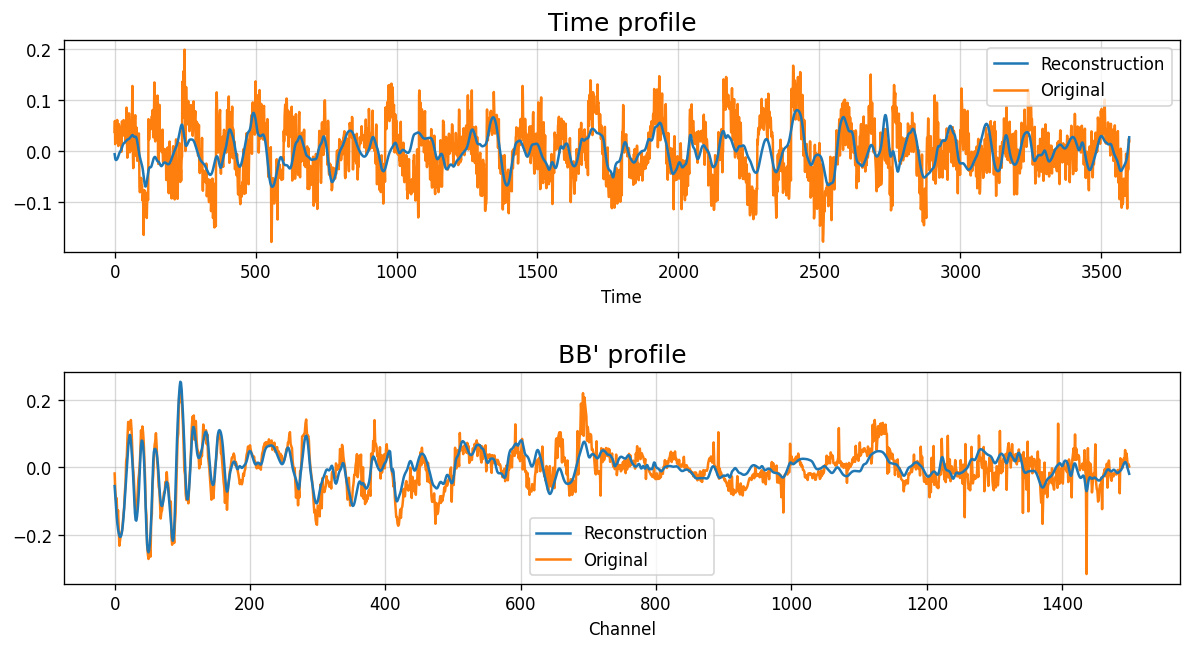

In [11]:
IX = 1000; IT = 1000;
x = 2*np.arange(NX)/(NX-1)-1
t = 2*np.arange(NT)/(NT-1)-1

fig = plt.figure(figsize = (12, 6), dpi = 120)
plt.subplots_adjust(hspace = 0.57)
plt.subplot(2, 1, 1)

d = np.stack([t, x[IX] * np.ones(int(NT))], axis = -1)
aa = model.predict(d).reshape(1, int(NT), 1)[:, :, 0]

plt.plot(aa.T, label = 'Reconstruction', zorder = 9)
plt.plot(TRAIN_DATA[IX, :], label = 'Original')

# plt.plot(np.diff(aa)[0], label = 'Gradient Reconstruction', zorder = 9)
# plt.plot(np.diff(TRAIN_DATA[IX, :]), label = 'Gradient Original')

plt.grid(True, alpha = 0.5)
plt.title("Time profile", fontsize = 15)
plt.legend(fontsize = 10)
plt.xlabel("Time", fontsize = 10)

plt.subplot(2, 1, 2)
d = np.stack([t[IT]* np.ones(int(NX)), x], axis = -1)
bb = model.predict(d).reshape(1, int(NX), 1)[:, :, 0]

plt.plot(bb.T, label = 'Reconstruction', zorder = 9)
plt.plot(TRAIN_DATA[:, IT], label = 'Original')

# # plt.plot(np.diff(bb)[0], label = 'Gradient Reconstruction', zorder = 90)
# # plt.plot(np.diff(TRAIN_DATA[::DNX, IT]), label = 'Gradient Original')

plt.legend(loc = 'upper right')
plt.grid(True, alpha = 0.5)
plt.title("BB' profile", fontsize = 15)
plt.legend(fontsize = 10)
plt.xlabel("Channel", fontsize = 10)

# plt.savefig(f"./profile.pdf", bbox_inches = 'tight', dpi = 300)
# plt.close()

# F-K misfit

In [67]:
nnx = TRAIN_DATA.shape[0]
nns = TRAIN_DATA.shape[1]
dx = 2.0419047
dt = 1/20
freq = np.fft.fftshift(np.fft.fftfreq(nns, d=5*dt))
knum = np.fft.fftshift(np.fft.fftfreq(nnx, d=5*dx))

# Calculate the frequency-wavenumber spectrum
ft2_resc = np.fft.fftshift(np.fft.fft2(predict))
ft2_resc = np.log10(abs(ft2_resc)) # this is not normalized

ft2_orig = np.fft.fftshift(np.fft.fft2(TRAIN_DATA))
ft2_orig = np.log10(abs(ft2_orig)) # this is not normalized

(-0.01, 0.01)

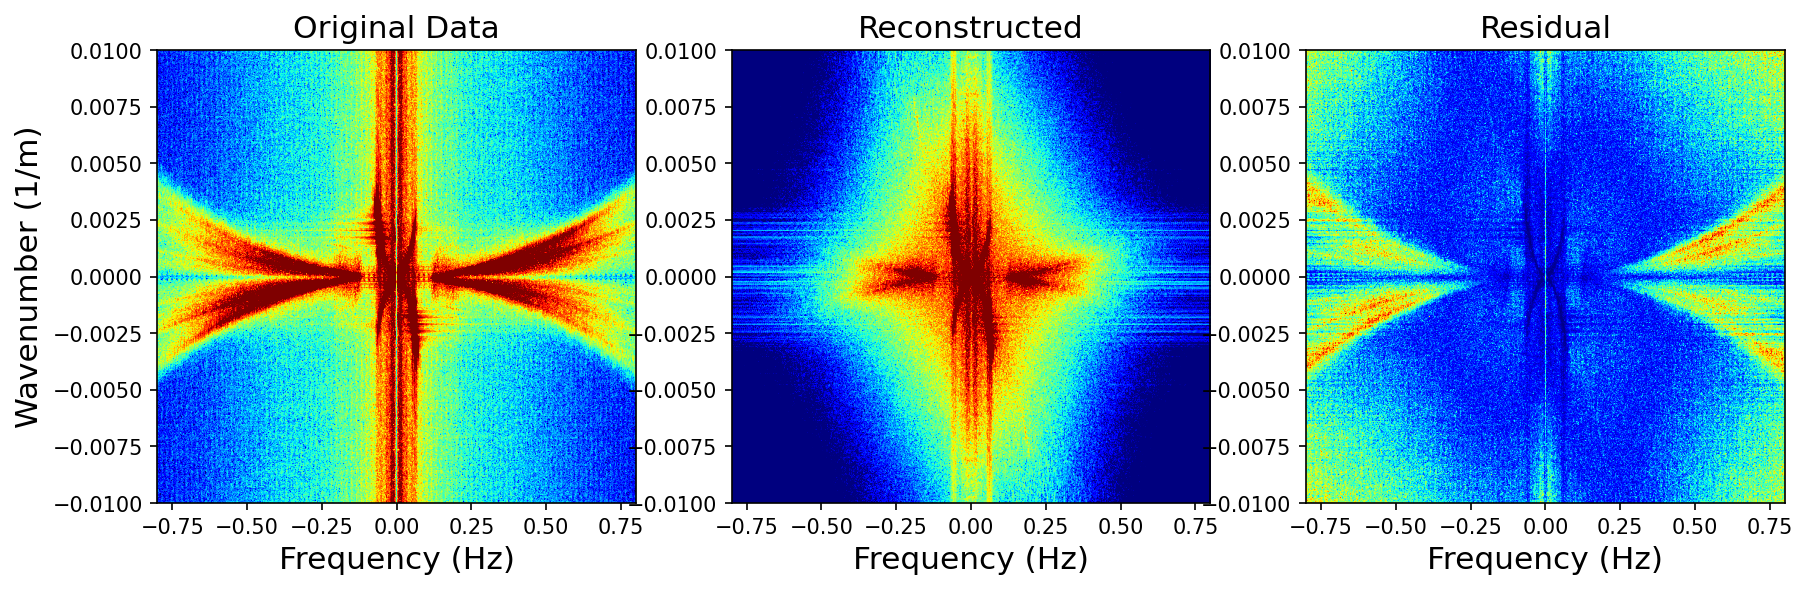

In [73]:
xlim = [-0.8, 0.8]; ylim = [-0.01,0.01]
plt.figure(figsize= (14, 4), dpi = 150)
plt.subplot(1,3,1)
plt.imshow(np.abs(ft2_orig), cmap='jet', aspect = "auto", 
           extent=[min(freq),max(freq),min(knum),max(knum)], 
           vmin=1,vmax=3)
plt.title("Original Data", fontsize = 15)
plt.ylabel("Wavenumber (1/m)", fontsize = 15)
plt.xlabel("Frequency (Hz)", fontsize = 15)
plt.xlim(xlim)
plt.ylim(ylim)

plt.subplot(1,3,2)
plt.imshow(np.abs(ft2_resc), cmap='jet', aspect = "auto", 
           extent=[min(freq),max(freq),min(knum),max(knum)], 
           vmin=1,vmax=3)
# plt.colorbar()
plt.title("Reconstructed", fontsize = 15)
plt.xlabel("Frequency (Hz)", fontsize = 15)
plt.xlim(xlim)
plt.ylim(ylim)

plt.subplot(1,3,3)
plt.imshow(np.abs(ft2_orig-ft2_resc), cmap='jet', aspect = "auto", 
           extent=[min(freq),max(freq),min(knum),max(knum)], vmax = 2)
# plt.colorbar(location = 'bottom')
plt.title("Residual", fontsize = 15)
plt.xlabel("Frequency (Hz)", fontsize = 15)
plt.xlim(xlim)
plt.ylim(ylim)

# plt.savefig(f"./fk_res.pdf", bbox_inches = 'tight', dpi = 150)
# plt.close()

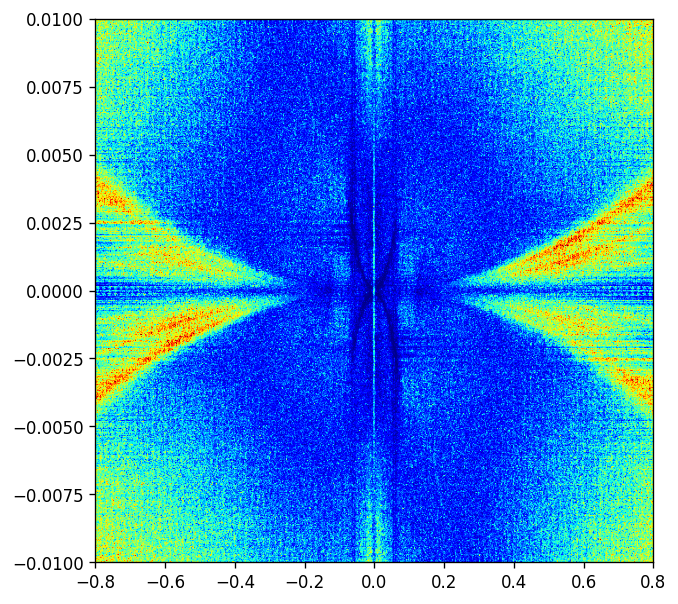

In [74]:
plt.figure(figsize= (6, 6), dpi = 120)
plt.imshow(np.abs(ft2_orig-ft2_resc), cmap='jet', aspect = "auto", 
           extent=[min(freq),max(freq),min(knum),max(knum)], vmax = 2)
# plt.colorbar(location = 'bottom')
# plt.title("Residual", fontsize = 15)
# plt.xlabel("Frequency (Hz)", fontsize = 15)
plt.xlim(xlim)
plt.ylim(ylim)
plt.savefig("siren-deep-fk.pdf", bbox_inches = 'tight')